In [1]:
import numpy
import mitsuba as mi 
mi.set_variant("cuda_ad_rgb")
import matplotlib.patches as patches
import drjit as dr
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from PDE2D.Coefficient import *
from PDE2D.utils import *
from PDE2D.BoundaryShape import *
from PDE2D.Solver import *
from mitsuba import Float,Point2f 
from PDE2D import GreenSampling, Split

In [2]:
green = GreenSampling.Polynomial
use_accel = True

In [3]:
source_p = {}
source_p["radius"] = 0.5
source_p["val"] = 100
def source(points, params):
    return dr.select(dr.norm(points) <= params["radius"], params["val"], 0.0)

f = FunctionCoefficient("f", source_p, source)
#f = ConstantCoefficient("f", 0)

In [5]:
bbox = [[-1.05, -1.05], [1.05, 1.05]]
resolution_image = [256, 256]
spp_image = 512
epsilon = 1e-5

res = 256
spp_boundary = 2 ** 22

radius = 1
computation_radius = 0.8

parameters = {}
parameters["freq"] = 2
parameters["bias"] = 6
parameters["scale"] = 12


def boundary_dirichlet(points, parameters):
    angle = dr.atan2(points[0], points[1])
    return parameters["scale"] * dr.sin(angle * parameters["freq"]) + parameters["bias"]



α = ConstantCoefficient("diffusion", value = 1)
neumann = ConstantCoefficient("neumann" ,0)
dirichlet = FunctionCoefficient("dirichlet", parameters, boundary_dirichlet)
σ = ConstantCoefficient("screening", 10)
angle_partition = np.array([0, dr.pi/2, dr.pi, 3 * dr.pi/2])
dirichlet_map = np.array([1, 0, 1, 0])
shape = CircleShape(origin=Point2f(0., 0.), radius=radius, epsilon= epsilon,dirichlet=[dirichlet],
                    neumann=[neumann], dirichlet_map=dirichlet_map, angle_partition=angle_partition)
data_holder = DataHolder(shape = shape, α = α, σ = σ, f=f, default_majorant = 100)

In [6]:
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (10,10))
#data_holder.visualize(ax1, ax2, ax3, ax4)

Text(0.5, 1.0, 'Constant')

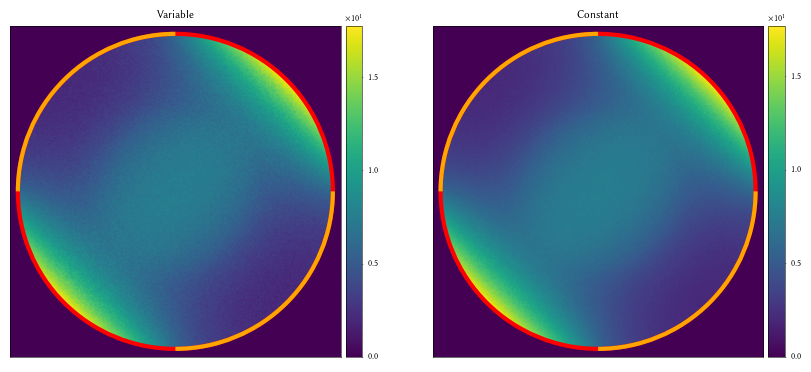

In [7]:
points = create_image_points(bbox, resolution_image, spp_image)
wos_v = WostVariable(data_holder, green_sampling=green, use_accelaration=use_accel)
wos_c = WostConstant(data_holder, green_sampling=green)

L_v, _ = wos_v.solve(points_in = points, split = Split.Naive)
image_v, tensor = create_image_from_result(L_v, resolution_image)
L_c, _ = wos_c.solve(points_in = points)
image_c, tensor = create_image_from_result(L_c, resolution_image)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10, 5])
plot_image(image_v[0], ax1)
plot_image(image_c[0], ax2)
shape.sketch(ax1, bbox, resolution_image)
shape.sketch(ax2, bbox, resolution_image)
ax1.set_title("Variable")
ax2.set_title("Constant")

Mean:
-0.00044540357
Variance:
0.05347213


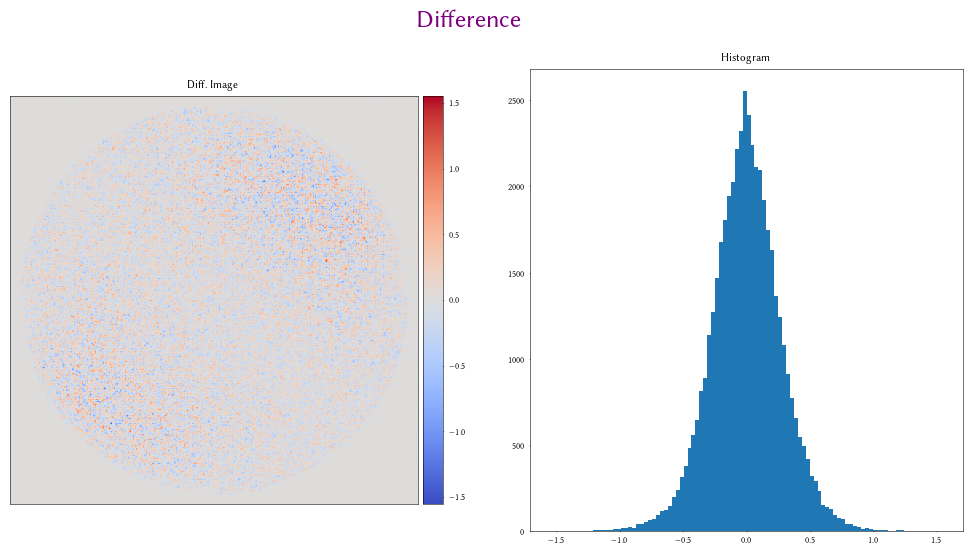

In [8]:
sketch_diff(image_v[0], image_c[0], max_range = 3)